# What drives the price of a car?


## Practical Application Project: Analyzing Used Car Prices
### Introduction
Welcome to our practical application project, a significant part of the Artificial Intelligence and Machine Learning curriculum at UC Berkeley. This project uses a large Kaggle dataset of used car pricing information, and aims to provide real-world insights and actionable data analytics catered specifically to automobile dealers. In the ever-evolving landscape of the used car market, dealers constantly face the challenge of setting competitive and profitable prices. Understanding the factors that significantly influence used car prices is paramount for sustaining business success and customer satisfaction.

### Objective
The core objective of this project is to unravel the mystery of which factors have a more substantial impact on the prices of used cars: the manufacturing year ('year') or the mileage ('odometer'). These two factors traditionally play critical roles in determining a vehicle's value, but their relative importance is not always clear. By leveraging data-driven insights, we aim to clarify this ambiguity and provide a foundation for informed decision-making.

### Target Audience
The primary audience for this project is automobile dealers who operate in the used car market. These professionals are continually seeking insights that can lead to better inventory selections, pricing strategies, and ultimately, higher profit margins. By understanding the nuances of how different factors affect car valuations, dealers can optimize their business practices to align with market dynamics and consumer preferences.

### Approach
We approach this analysis by employing various machine learning techniques and data visualization tools to examine a comprehensive dataset of used car listings. By focusing on 'year' and 'odometer' readings among other potential influencing factors, we dissect the complex interplay between these variables and car prices. Through regression analysis, correlation studies, and other statistical methods, we aim to provide a clear picture of the factors that most significantly impact used car prices.

In doing so, we hope to equip automobile dealers with the knowledge to make better-informed decisions about which cars to stock, how to price them, and how to market them to prospective buyers. With a deeper understanding of these critical factors, dealers can enhance their competitive edge in the market, better meet customer needs, and drive their businesses forward.

### Data cleaning and bucketization:

The first block of code loads a CSV file containing used vehicle data into a Pandas DataFrame, then defines and applies a clean_data function to this DataFrame.

The clean_data function systematically cleans the data by removing unnecessary columns (like 'id' and 'VIN'), handling missing values by dropping columns with a high percentage of missing data and filling in remaining missing values for numerical and categorical data with median and mode values respectively. It also converts the 'year' column to integer data type, removes duplicate records, filters out anomalies or outliers based on predefined criteria for 'price', 'odometer', and 'year', and categorizes 'odometer' readings into 10 buckets for better analysis.

In [5]:
import pandas as pd
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
vehicles_path = 'Users/apeacock/vehicles.csv'  
vehicles_df = read_csv(vehicles_path)

def clean_data(df):
    # Drop specified columns
    df = df.drop(columns=['id', 'VIN'], errors='ignore')  # Ensure to use df = df.drop(...) for proper assignment

    # Define the threshold for dropping columns based on missing values
    threshold = 50  # Percentage of missing values threshold to drop column

    # Handle missing values
    missing_values = df.isnull().mean() * 100
    columns_to_drop = missing_values[missing_values > threshold].index
    df = df.drop(columns=columns_to_drop, inplace=False)  # Corrected inplace argument

    # Fill missing values
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
    df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

    # Convert data types
    df['year'] = df['year'].astype(int)

    # Remove duplicates
    df = df.drop_duplicates()

    # Remove anomalies and outliers based on common sense and statistical measures
    current_year = pd.Timestamp('now').year
    df = df[(df['price'] > 1000) & (df['price'] <= 100000)]
    df = df[(df['odometer'] > 0) & (df['odometer'] <= 300000)]
    df = df[(df['year'] > 2007) & (df['year'] <= current_year)]

    # Remove manufacturer 'morgan'
    df = df[df['manufacturer'] != 'morgan']

    # Bucketize 'odometer' into 10 categories
    df['odometer_bucket'] = pd.qcut(df['odometer'], 10, labels=False, duplicates='drop')

    return df

# Clean the data
vehicles_cleaned_df = clean_data(vehicles_df)

# Preview the cleaned data
print(vehicles_cleaned_df.head())

StatementMeta(ce56c929-a8c5-41c0-8fe4-418cb5d9b30c, 4, 10, Finished, Available)

                   region  price  year manufacturer  model condition  \
0                prescott   6000  2013         ford  f-150      good   
1            fayetteville  11900  2013         ford  f-150      good   
2            florida keys  21000  2013         ford  f-150      good   
3  worcester / central MA   1500  2013         ford  f-150      good   
4              greensboro   4900  2013         ford  f-150      good   

     cylinders fuel  odometer title_status transmission drive   type  \
0  6 cylinders  gas   85548.0        clean    automatic   4wd  sedan   
1  6 cylinders  gas   85548.0        clean    automatic   4wd  sedan   
2  6 cylinders  gas   85548.0        clean    automatic   4wd  sedan   
3  6 cylinders  gas   85548.0        clean    automatic   4wd  sedan   
4  6 cylinders  gas   85548.0        clean    automatic   4wd  sedan   

  paint_color state  odometer_bucket  
0       white    az                5  
1       white    ar                5  
2       white    

### Feature Engineering: Combining Manufacturer and Model
In our analysis of the used vehicles dataset, a new feature called 'ManufacturerModel' was engineered. This feature concatenates the 'manufacturer' and 'model' fields, creating a combined descriptor for each vehicle, such as 'ford f150' or 'chevy silverado'. This approach aims to provide a more granular and descriptive insight into the dataset by distinctly identifying vehicles not just by their make or model, but by their combined identity, which is more reflective of how consumers and dealers typically refer to and think about vehicles.

The rationale behind this feature engineering step was to facilitate a focused analysis on top-selling models, simplifying the dataset to enhance interpretability and relevance. By narrowing down the examination to well-known and high-volume vehicles, we ensure our findings are practical and applicable to the largest market segments. The presence of expected popular models like 'ford f150' and 'chevy silverado' ranking high validates the approach, confirming that our data reflects real-world market trends and consumer preferences. This strategic focus aims to provide automobile dealers with actionable insights tailored to the most impactful segments of the market.

In [ ]:
# Engineer a new feature 'ManufacturerModel' that combines 'manufacturer' and 'model'
vehicles_cleaned_df['ManufacturerModel'] = vehicles_cleaned_df['manufacturer'] + ' ' + vehicles_cleaned_df['model']

StatementMeta(ce56c929-a8c5-41c0-8fe4-418cb5d9b30c, 4, 11, Finished, Available)

In [7]:
top_models = vehicles_cleaned_df.groupby(['manufacturer', 'model']).size().reset_index(name='count')
top_models = top_models.sort_values(by='count', ascending=False).head(50)

# Merge this information back to the original dataframe to filter for only top 50 manufacturer-models
top_vehicles_df = pd.merge(vehicles_cleaned_df, top_models[['manufacturer', 'model']], on=['manufacturer', 'model'], how='inner')

# Now top_vehicles_df contains only the entries for the top 50 manufacturer-model combinations
print(top_vehicles_df.head())

StatementMeta(ce56c929-a8c5-41c0-8fe4-418cb5d9b30c, 4, 12, Finished, Available)

                   region  price  year manufacturer  model condition  \
0                prescott   6000  2013         ford  f-150      good   
1            fayetteville  11900  2013         ford  f-150      good   
2            florida keys  21000  2013         ford  f-150      good   
3  worcester / central MA   1500  2013         ford  f-150      good   
4              greensboro   4900  2013         ford  f-150      good   

     cylinders fuel  odometer title_status transmission drive   type  \
0  6 cylinders  gas   85548.0        clean    automatic   4wd  sedan   
1  6 cylinders  gas   85548.0        clean    automatic   4wd  sedan   
2  6 cylinders  gas   85548.0        clean    automatic   4wd  sedan   
3  6 cylinders  gas   85548.0        clean    automatic   4wd  sedan   
4  6 cylinders  gas   85548.0        clean    automatic   4wd  sedan   

  paint_color state  odometer_bucket ManufacturerModel  
0       white    az                5        ford f-150  
1       white    ar 

### Exploratory Data Analysis

This block of code is primarily focused on generating summary statistics and visualizations for the top_vehicles_df, which contains data filtered to only include top-selling vehicle models. Here's a breakdown of what each section accomplishes:

Execution Time Tracking: Utilizes timestamps to monitor how long each section of code takes to execute, providing insight into the computational efficiency of data processing and visualization tasks.

Styling: Sets the aesthetic style of the plots to 'seaborn-whitegrid', which provides a clean and readable background for the data visualizations.

Summary Statistics: Generates and prints summary statistics for numerical features (like price and year) and categorical features (like manufacturer and model) within the top-selling vehicle models dataset. This offers a comprehensive view of the central tendencies, dispersion, and overall distribution of the data.

Distribution of Car Prices and Years: Creates histograms to visualize the distribution of car prices and years in the dataset. These plots help identify common price ranges and model years among the top-selling vehicles, indicating market trends and consumer preferences.

Boxplot for Car Prices by Manufacturer: Displays a boxplot categorized by manufacturer, highlighting the median, quartiles, and potential outliers in car prices for each manufacturer. This allows for a comparison of price ranges and variability between different brands within the top-selling models.

Scatter Plot for Price vs. Odometer Reading: Illustrates the relationship between car prices and odometer readings through a scatter plot, helping to understand how mileage affects the valuation of top-selling vehicle models.

Correlation Heatmap: Showcases a heatmap of correlation coefficients between numerical features in the dataset. This visualization aids in identifying potential relationships or dependencies between variables, such as the impact of year and odometer readings on price.

StatementMeta(ce56c929-a8c5-41c0-8fe4-418cb5d9b30c, 4, 23, Finished, Available)

Summary Statistics for Numerical Features:
               price          year       odometer  odometer_bucket
count   57419.000000  57419.000000   57419.000000     57419.000000
mean    19752.694753   2014.166565   94499.522022         5.472579
std     13464.754194      3.321717   53198.264117         2.636961
min      1006.000000   2008.000000       1.000000         0.000000
25%      9250.000000   2012.000000   51516.500000         4.000000
50%     15995.000000   2014.000000   92720.000000         6.000000
75%     26995.000000   2017.000000  130765.000000         8.000000
max    100000.000000   2022.000000  300000.000000         9.000000

Summary Statistics for Categorical Features:
              region manufacturer  model condition    cylinders   fuel  \
count          57419        57419  57419     57419        57419  57419   
unique           402           14     50         6            7      5   
top     grand rapids         ford  f-150      good  6 cylinders    gas   
freq        

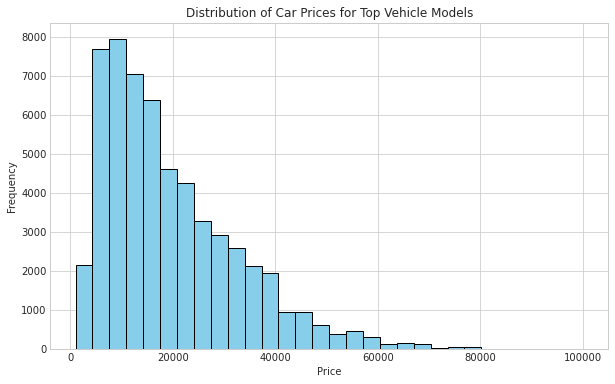

Distribution of car prices for top vehicle models plotted. Time elapsed: 0.49 seconds


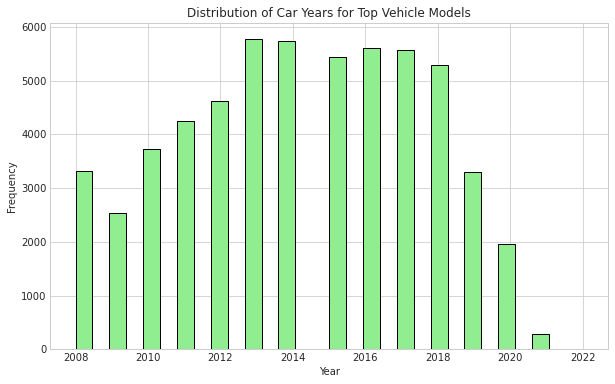

Distribution of car years for top vehicle models plotted. Time elapsed: 0.81 seconds


NameError: name 'sns' is not defined

In [18]:
# Add timestamp for starting execution
start_time = time.time()

# Set the aesthetic style of the plots
plt.style.use("seaborn-whitegrid")  

# Summary statistics for numerical features in top_vehicles_df
print("Summary Statistics for Numerical Features:")
print(top_vehicles_df.describe())

# Summary statistics for categorical features in top_vehicles_df
print("\nSummary Statistics for Categorical Features:")
print(top_vehicles_df.describe(include='object'))

# Distribution of car prices in top_vehicles_df
plt.figure(figsize=(10, 6))
plt.hist(top_vehicles_df['price'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Car Prices for Top Vehicle Models')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Add timestamp after plotting distribution of car prices
print(f"Distribution of car prices for top vehicle models plotted. Time elapsed: {time.time() - start_time:.2f} seconds")

# Distribution of car years in top_vehicles_df
plt.figure(figsize=(10, 6))
plt.hist(top_vehicles_df['year'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Car Years for Top Vehicle Models')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

# Add timestamp after plotting distribution of car years
print(f"Distribution of car years for top vehicle models plotted. Time elapsed: {time.time() - start_time:.2f} seconds")

# Boxplot for car prices by manufacturer in top_vehicles_df
plt.figure(figsize=(14, 8))
sorted_idx = top_vehicles_df.groupby('manufacturer')['price'].median().sort_values().index
sns.boxplot(x='price', y='manufacturer', data=top_vehicles_df, order=sorted_idx, palette='light:m_r', orient='h')
plt.title('Car Prices by Manufacturer for Top Vehicle Models')
plt.xlabel('Price')
plt.ylabel('Manufacturer')
plt.show()

# Add timestamp after plotting boxplot for car prices by manufacturer
print(f"Boxplot for car prices by manufacturer for top vehicle models plotted. Time elapsed: {time.time() - start_time:.2f} seconds")

# Scatter plot for price vs. odometer in top_vehicles_df
plt.figure(figsize=(10, 6))
plt.scatter(x='odometer', y='price', data=top_vehicles_df, alpha=0.5)
plt.title('Car Price vs. Odometer Reading for Top Vehicle Models')
plt.xlabel('Odometer (miles)')
plt.ylabel('Price ($)')
plt.show()

# Add timestamp after plotting scatter plot for price vs. odometer
print(f"Scatter plot for price vs. odometer for top vehicle models plotted. Time elapsed: {time.time() - start_time:.2f} seconds")

# Correlation Heatmap for top_vehicles_df
plt.figure(figsize=(10, 8))
corr = top_vehicles_df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap for Top Vehicle Models')
plt.show()

# Add timestamp after plotting correlation heatmap
print(f"Correlation heatmap for top vehicle models plotted. Total execution time: {time.time() - start_time:.2f} seconds")

StatementMeta(ce56c929-a8c5-41c0-8fe4-418cb5d9b30c, 4, 13, Finished, Available)

ford f-150
chevrolet silverado 1500
toyota tacoma
honda odyssey
ford Scion iM Hatchback 4D
subaru forester
ford mustang
nissan altima
hyundai elantra
honda accord
ford escape
toyota corolla
kia soul
chevrolet silverado
ram 2500
ram 1500
dodge grand caravan
jeep grand cherokee
chevrolet traverse
dodge charger
ram 3500
toyota tundra
chevrolet tahoe
toyota prius
toyota camry
volkswagen jetta
chevrolet malibu
chevrolet silverado 2500hd
mercedes-benz c-class
gmc sierra 1500
jeep wrangler
ford f-250
hyundai sonata
ford fusion
chevrolet impala
ram 1500 crew cab big horn
ford edge
honda cr-v
nissan rogue
ford explorer
gmc acadia
jeep wrangler unlimited
chevrolet equinox
honda civic
ford focus
gmc sierra
chevrolet cruze
subaru outback
nissan sentra
toyota rav4


#### Analysis and visualization of regressions

This block of code performs a comprehensive analysis and visualization for the top 10 most frequent vehicle models in the top_vehicles_df DataFrame. 

Identify Top Models: It identifies the top 10 vehicle models based on frequency in the dataset and stores their names.

Set Up Plotting Area: Initializes a plotting area with a predefined size to accommodate multiple subplots.

Iterate Through Each Top Model: For each of the top 10 models:

Filters the DataFrame to only include data for that specific model.
Sets up independent (X: year) and dependent (y: price) variables for regression analysis.
Performs linear regression, fitting a model to predict price from the year, and then predicts price for the observed years.
Performs polynomial regression with a degree of 2, transforming the 'year' data into polynomial features, fitting the model, and then predicting prices for a generated range of years to create a smooth curve.
Generates subplots within the figure, plotting the actual data points (price vs. year) and the predicted price lines from both linear and polynomial regressions. It adds appropriate labels, titles, and legends to each plot.
Calculates and prints the Root Mean Square Error (RMSE) for both regression models, providing a measure of model performance - lower RMSE values indicate a better fit.
Visualization and Layout Adjustment: After plotting all subplots for each top model, it adjusts the layout to ensure that each subplot is readable, configuring spacing between individual plots.

Display: Finally, it displays the combined plot containing subplots for each of the top 10 models. This visual comparison helps to understand how well the year of a vehicle predicts its price for each model, comparing linear and polynomial trends.

This analysis is particularly useful for understanding the pricing trends over the years for the most popular models, helping automobile dealers and analysts to understand how vehicle values depreciate over time and how this trend varies across different models. It provides both quantitative (RMSE values) and qualitative (trend lines in plots) insights into the relationship between the manufacturing year and the price for the top models.

StatementMeta(ce56c929-a8c5-41c0-8fe4-418cb5d9b30c, 4, 17, Finished, Available)

f-150 - Linear RMSE: 8464.709719493789, Polynomial RMSE: 8306.724274558896
silverado 1500 - Linear RMSE: 6483.77730127227, Polynomial RMSE: 6405.389484199841
1500 - Linear RMSE: 7240.982337655383, Polynomial RMSE: 6910.266675877843
escape - Linear RMSE: 3117.0963017794056, Polynomial RMSE: 2864.84881367457
altima - Linear RMSE: 3259.896048638188, Polynomial RMSE: 2983.569511028952
civic - Linear RMSE: 3141.0595792045174, Polynomial RMSE: 3039.7583929462558
explorer - Linear RMSE: 5365.096908386397, Polynomial RMSE: 4500.93272367299
camry - Linear RMSE: 3362.654013204696, Polynomial RMSE: 3080.113296853977
accord - Linear RMSE: 3279.7315211122545, Polynomial RMSE: 3003.512640694253
silverado - Linear RMSE: 10199.309751851999, Polynomial RMSE: 10097.28291144219


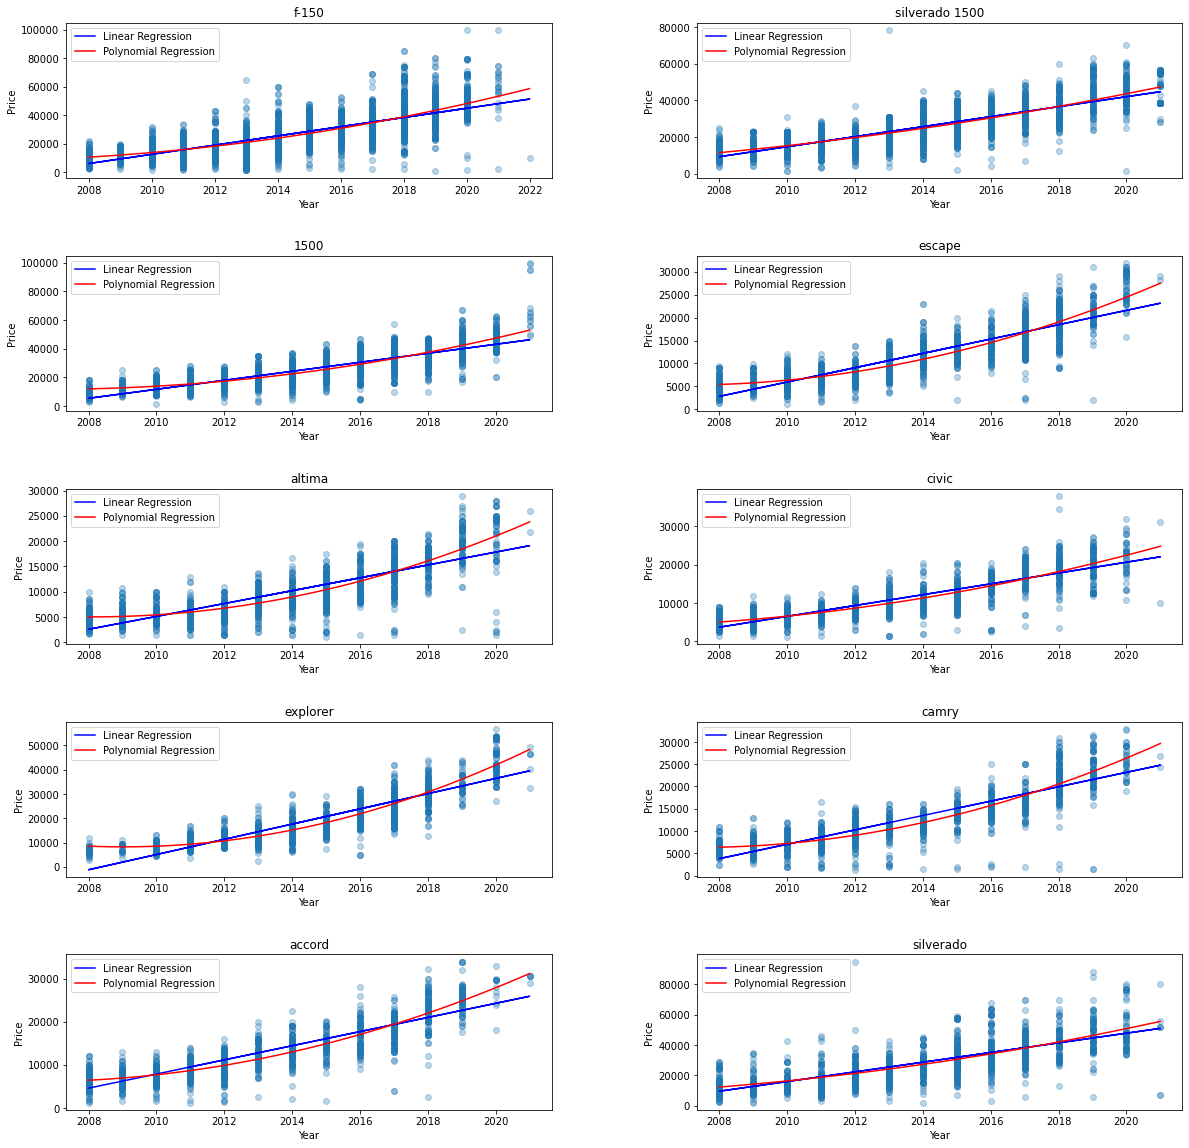

In [12]:
top_10_models = top_vehicles_df['model'].value_counts().head(10).index

# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

for i, model in enumerate(top_10_models, 1):
    # Filter the DataFrame for the current model
    model_df = top_vehicles_df[top_vehicles_df['model'] == model]

    # Set up X (year) and y (price)
    X = model_df[['year']]
    y = model_df['price']

    # Linear regression
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)
    y_pred_lin = lin_reg.predict(X)

    # Polynomial regression
    poly_features = PolynomialFeatures(degree=2)
    X_poly = poly_features.fit_transform(X)
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly, y)

    # Generating a range of years for prediction
    X_sequence = np.linspace(X['year'].min(), X['year'].max(), 50).reshape(-1, 1)  # Generate years for prediction
    y_pred_poly = poly_reg.predict(poly_features.transform(X_sequence))

    # Plotting
    plt.subplot(5, 2, i)  # Plotting in a grid
    plt.scatter(X, y, alpha=0.3)
    plt.plot(X, y_pred_lin, color='blue', label='Linear Regression')
    plt.plot(X_sequence, y_pred_poly, color='red', label='Polynomial Regression')
    plt.title(f'{model}')
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.legend()

    # Calculate errors
    rmse_lin = np.sqrt(mean_squared_error(y, y_pred_lin))
    rmse_poly = np.sqrt(mean_squared_error(y, poly_reg.predict(X_poly)))
    print(f"{model} - Linear RMSE: {rmse_lin}, Polynomial RMSE: {rmse_poly}")

# Adjust layout for better readability
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
plt.show()

### Coefficients:

Year: The coefficient for 'year' is approximately 2059.56. This means that, all else being equal, each additional year increases the car's price by about 2059.56. For example a car from 2020 is expected to be around 2059.56 more expensive than a similar car from 2019, adjusting for the same odometer reading.
Odometer: The coefficient for 'odometer' is approximately -0.036. This indicates that for each additional mile on the car, the price decreases by about 3.6 cents. While this might seem small, consider that for every additional 10,000 miles, the car's price decreases by around $360.

### Root Mean Squared Error (RMSE):

The RMSE is about 10673.91. This metric tells you how much error there is in the model's predictions. In this context, it means that, on average, the model's predictions for car prices are off by about $10,673.91. While this might seem high, the acceptability of this error depends on the price range of the used cars being sold.

### R-squared:

The R-squared value is approximately 0.377. This means that about 37.7% of the variability in car prices can be explained by the year and odometer reading together. While this is not extremely high, it does indicate that these factors have a significant impact on car prices but also suggests that there are other factors not included in the model that are influencing the price.
How can this help used car salesmen?
Pricing Strategy: Understanding the average impact of year and mileage can help salesmen price cars more effectively. For example, they can justify higher prices for newer models or adjust prices based on mileage. They could also use this information to highlight the value of cars that are newer or have lower mileage.

Inventory Selection: Salesmen might prioritize acquiring and selling cars from recent years with lower mileage, as the model indicates these are likely to be valued higher by buyers.

Marketing and Negotiation: When discussing prices with customers, salesmen can use the data to justify the pricing. For example, explaining how newer model years are priced higher, or the impact of mileage on price.

Targeted Promotions: Salesmen might create promotions or discounts for older or higher-mileage cars that are harder to sell, based on the predicted decrease in price.

While the R-squared value suggests that there are other significant factors affecting car prices, year and mileage are clearly important and can serve as a baseline for pricing strategy. However, salesmen should also consider other attributes not included in this model, such as car condition, brand, market trends, and additional features, when pricing their vehicles.

StatementMeta(ce56c929-a8c5-41c0-8fe4-418cb5d9b30c, 4, 18, Finished, Available)

f-150 - Odometer Linear RMSE: 9621.827375855544, Odometer Polynomial RMSE: 9499.012258511873
silverado 1500 - Odometer Linear RMSE: 7454.966425430839, Odometer Polynomial RMSE: 7394.796599172608
1500 - Odometer Linear RMSE: 7981.781930942827, Odometer Polynomial RMSE: 7788.755738113287
escape - Odometer Linear RMSE: 3771.1210999804134, Odometer Polynomial RMSE: 3656.609648493998
altima - Odometer Linear RMSE: 3824.823396981237, Odometer Polynomial RMSE: 3769.3533987361257
civic - Odometer Linear RMSE: 3903.8463210563327, Odometer Polynomial RMSE: 3783.849888574001
explorer - Odometer Linear RMSE: 5844.892485622998, Odometer Polynomial RMSE: 5218.666439292179
camry - Odometer Linear RMSE: 4372.349607029786, Odometer Polynomial RMSE: 4138.845095655132
accord - Odometer Linear RMSE: 4391.27162618103, Odometer Polynomial RMSE: 4220.845368152503
silverado - Odometer Linear RMSE: 11373.182060255858, Odometer Polynomial RMSE: 11174.44001830203


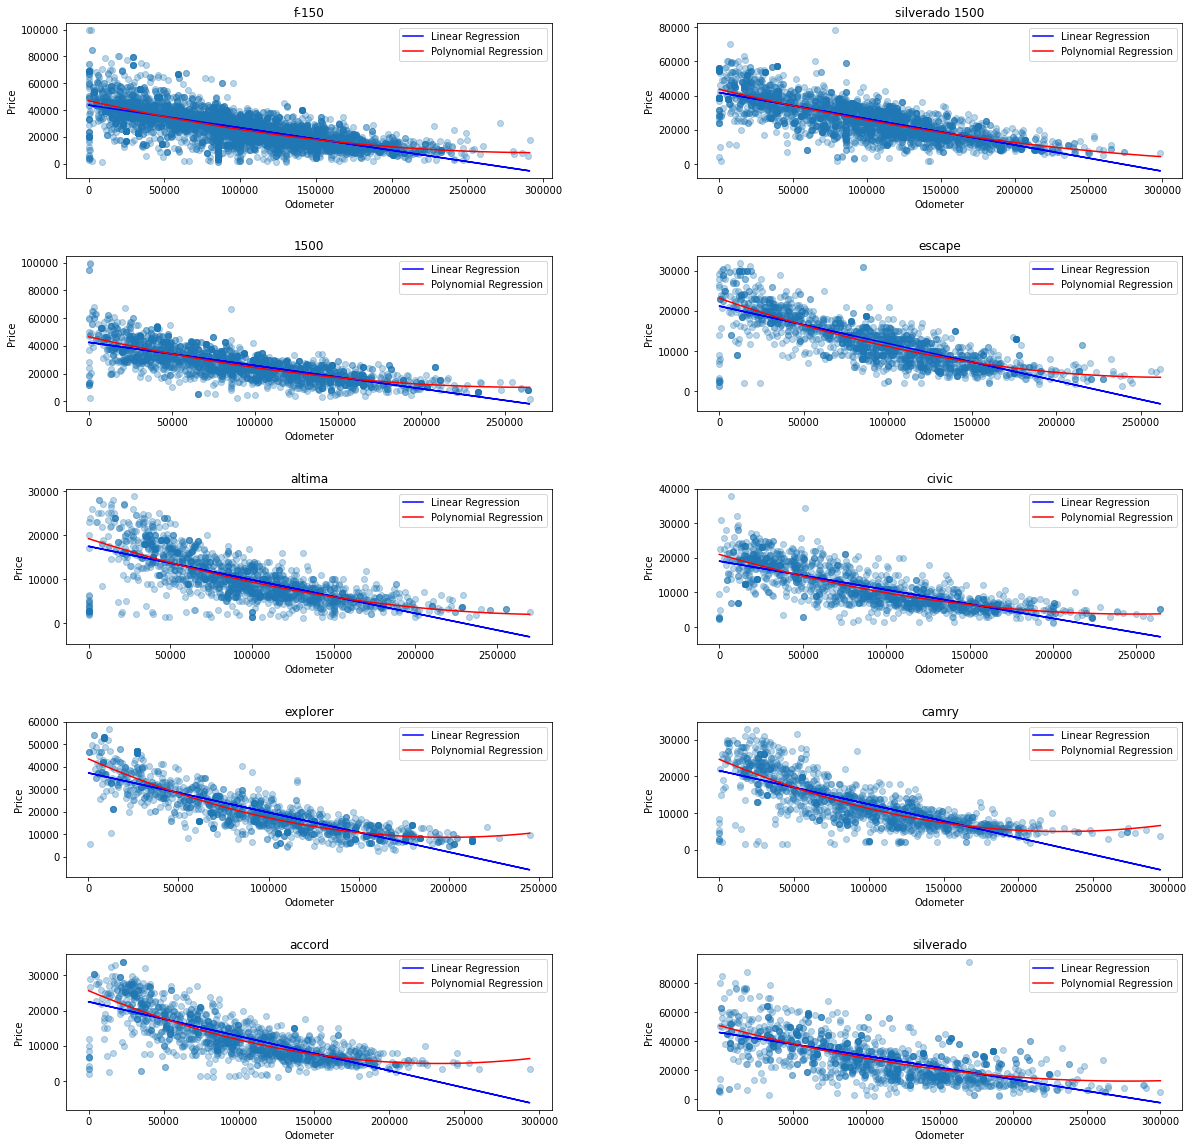

In [13]:
top_10_models = top_vehicles_df['model'].value_counts().head(10).index

# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

for i, model in enumerate(top_10_models, 1):
    # Filter the DataFrame for the current model
    model_df = top_vehicles_df[top_vehicles_df['model'] == model]

    # Set up X (odometer) and y (price)
    X = model_df[['odometer']]
    y = model_df['price']

    # Ensure data is sorted by odometer for consistent line plotting
    model_df = model_df.sort_values('odometer')
    
    # Linear regression
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)
    y_pred_lin = lin_reg.predict(X)

    # Polynomial regression
    poly_features = PolynomialFeatures(degree=2)
    X_poly = poly_features.fit_transform(X)
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly, y)

    # Generating a range of odometer readings for prediction
    X_sequence = np.linspace(X['odometer'].min(), X['odometer'].max(), 50).reshape(-1, 1)  # Generate odometer values for prediction
    y_pred_poly = poly_reg.predict(poly_features.transform(X_sequence))

    # Plotting
    plt.subplot(5, 2, i)  # Plotting in a grid
    plt.scatter(X, y, alpha=0.3)
    plt.plot(X, y_pred_lin, color='blue', label='Linear Regression')
    plt.plot(X_sequence, y_pred_poly, color='red', label='Polynomial Regression')
    plt.title(f'{model}')
    plt.xlabel('Odometer')
    plt.ylabel('Price')
    plt.legend()

    # Calculate errors
    rmse_lin = np.sqrt(mean_squared_error(y, y_pred_lin))
    rmse_poly = np.sqrt(mean_squared_error(y, poly_reg.predict(X_poly)))
    print(f"{model} - Odometer Linear RMSE: {rmse_lin}, Odometer Polynomial RMSE: {rmse_poly}")

# Adjust layout for better readability
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
plt.show()


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare your data
X = top_vehicles_df[['year', 'odometer']]  # Independent variables
y = top_vehicles_df['price']               # Dependent variable

# Split the data into training and testing sets for validation purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model building
model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients interpretation
print("Coefficients: \nYear: ", model.coef_[0], "\nOdometer: ", model.coef_[1])

# Prediction
y_pred = model.predict(X_test)

# Evaluate the model
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared: ", r2_score(y_test, y_pred))

StatementMeta(ce56c929-a8c5-41c0-8fe4-418cb5d9b30c, 4, 20, Finished, Available)

Coefficients: 
Year:  2059.557189705678 
Odometer:  -0.03639925940064435
Root Mean Squared Error:  10673.913008060052
R-squared:  0.3766792676845012


### Coefficients:

Year: The coefficient for 'year' is approximately 2059.56. This means that, all else being equal, each additional year increases the car's price by about 2059.56. For example a car from 2020 is expected to be around 2059.56 more expensive than a similar car from 2019, adjusting for the same odometer reading.
Odometer: The coefficient for 'odometer' is approximately -0.036. This indicates that for each additional mile on the car, the price decreases by about 3.6 cents. While this might seem small, consider that for every additional 10,000 miles, the car's price decreases by around $360.

### Root Mean Squared Error (RMSE):

The RMSE is about 10673.91. This metric tells you how much error there is in the model's predictions. In this context, it means that, on average, the model's predictions for car prices are off by about $10,673.91. While this might seem high, the acceptability of this error depends on the price range of the used cars being sold.

### R-squared:

The R-squared value is approximately 0.377. This means that about 37.7% of the variability in car prices can be explained by the year and odometer reading together. While this is not extremely high, it does indicate that these factors have a significant impact on car prices but also suggests that there are other factors not included in the model that are influencing the price.
How can this help used car salesmen?
Pricing Strategy: Understanding the average impact of year and mileage can help salesmen price cars more effectively. For example, they can justify higher prices for newer models or adjust prices based on mileage. They could also use this information to highlight the value of cars that are newer or have lower mileage.

Inventory Selection: Salesmen might prioritize acquiring and selling cars from recent years with lower mileage, as the model indicates these are likely to be valued higher by buyers.

Marketing and Negotiation: When discussing prices with customers, salesmen can use the data to justify the pricing. For example, explaining how newer model years are priced higher, or the impact of mileage on price.

Targeted Promotions: Salesmen might create promotions or discounts for older or higher-mileage cars that are harder to sell, based on the predicted decrease in price.

While the R-squared value suggests that there are other significant factors affecting car prices, year and mileage are clearly important and can serve as a baseline for pricing strategy. However, salesmen should also consider other attributes not included in this model, such as car condition, brand, market trends, and additional features, when pricing their vehicles.

In [16]:
# Standard deviation of the features
std_year = top_vehicles_df['year'].std()
std_odometer = top_vehicles_df['odometer'].std()

# Standardized impact
year_impact_std = 2059.56 * std_year  # Impact of one standard deviation increase in year
odometer_impact_std = -0.0364 * std_odometer  # Impact of one standard deviation increase in odometer

print("Standardized Year Impact: ", year_impact_std)
print("Standardized Odometer Impact: ", odometer_impact_std)

StatementMeta(ce56c929-a8c5-41c0-8fe4-418cb5d9b30c, 4, 21, Finished, Available)

Standardized Year Impact:  6841.275591015806
Standardized Odometer Impact:  -1936.4168138569878


StatementMeta(ce56c929-a8c5-41c0-8fe4-418cb5d9b30c, 3, 8, Finished, Available)

Summary Statistics for Numerical Features:
               price           year       odometer
count  341554.000000  341554.000000  341554.000000
mean    18982.059499    2010.949630   90299.602742
std     14510.449377       9.823113   62393.742805
min         1.000000    1900.000000       0.000000
25%      7450.000000    2008.000000   35931.000000
50%     15900.000000    2013.000000   84729.500000
75%     27990.000000    2017.000000  133552.750000
max    100000.000000    2022.000000  300000.000000

Summary Statistics for Categorical Features:
            region manufacturer   model condition    cylinders    fuel  \
count       341554       341554  341554    341554       341554  341554   
unique         404           42   27670         6            8       5   
top     central NJ         ford   f-150      good  6 cylinders     gas   
freq          2735        69339    9881    235896       215062  287860   

       title_status transmission   drive    type paint_color   state  
count     

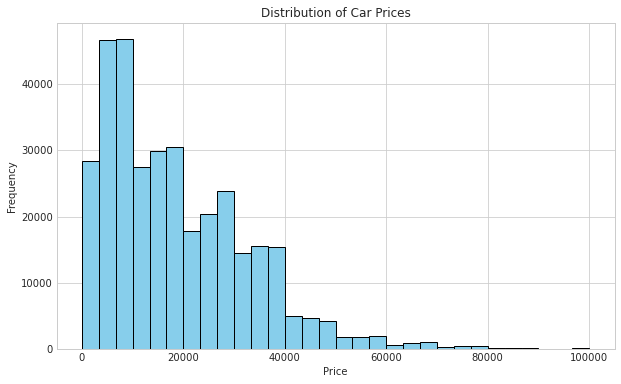

Distribution of car prices plotted. Time elapsed: 1.05 seconds


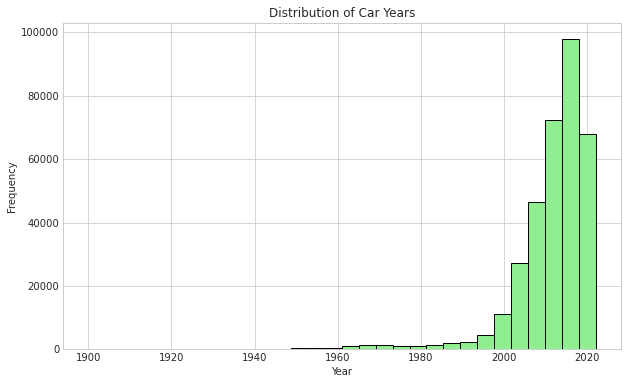

Distribution of car years plotted. Time elapsed: 1.41 seconds


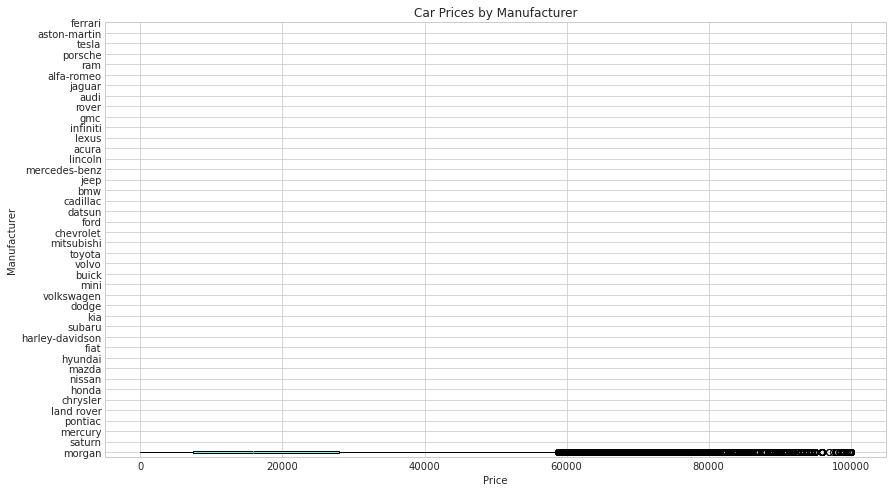

Boxplot for car prices by manufacturer plotted. Time elapsed: 1.97 seconds


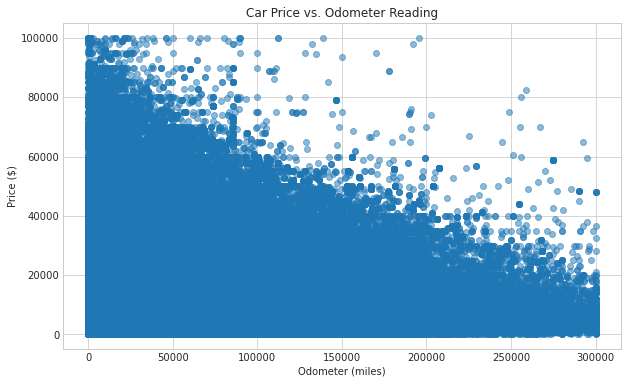

Scatter plot for price vs. odometer plotted. Time elapsed: 2.87 seconds


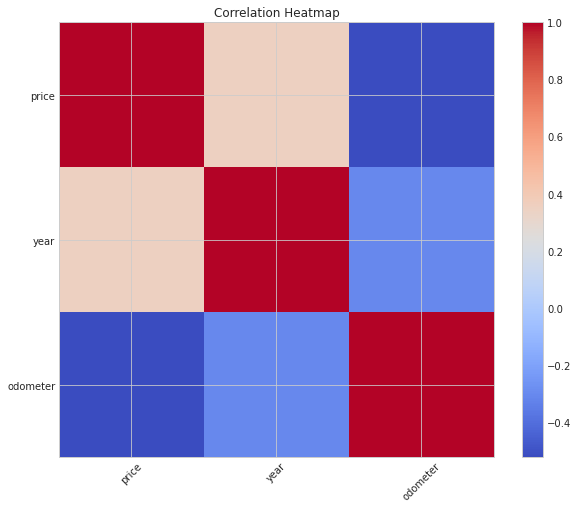

Correlation heatmap plotted. Total execution time: 3.13 seconds


In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Add timestamp for starting execution
start_time = time.time()

# Set the aesthetic style of the plots
plt.style.use("seaborn-whitegrid")  # You can choose any available style here

# Summary statistics for numerical features
print("Summary Statistics for Numerical Features:")
print(vehicles_cleaned_df.describe())

# Summary statistics for categorical features
print("\nSummary Statistics for Categorical Features:")
print(vehicles_cleaned_df.describe(include='object'))

# Distribution of car prices
plt.figure(figsize=(10, 6))
plt.hist(vehicles_cleaned_df['price'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Add timestamp after plotting distribution of car prices
print(f"Distribution of car prices plotted. Time elapsed: {time.time() - start_time:.2f} seconds")

# Distribution of car years
plt.figure(figsize=(10, 6))
plt.hist(vehicles_cleaned_df['year'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Car Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

# Add timestamp after plotting distribution of car years
print(f"Distribution of car years plotted. Time elapsed: {time.time() - start_time:.2f} seconds")

# Boxplot for car prices by manufacturer
plt.figure(figsize=(14, 8))
sorted_idx = vehicles_cleaned_df.groupby('manufacturer')['price'].median().sort_values().index
plt.boxplot(x='price', data=vehicles_cleaned_df, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Car Prices by Manufacturer')
plt.xlabel('Price')
plt.yticks(range(1, len(sorted_idx) + 1), sorted_idx)
plt.ylabel('Manufacturer')
plt.show()

# Add timestamp after plotting boxplot for car prices by manufacturer
print(f"Boxplot for car prices by manufacturer plotted. Time elapsed: {time.time() - start_time:.2f} seconds")

# Scatter plot for price vs. odometer
plt.figure(figsize=(10, 6))
plt.scatter(x='odometer', y='price', data=vehicles_cleaned_df, alpha=0.5)
plt.title('Car Price vs. Odometer Reading')
plt.xlabel('Odometer (miles)')
plt.ylabel('Price ($)')
plt.show()

# Add timestamp after plotting scatter plot for price vs. odometer
print(f"Scatter plot for price vs. odometer plotted. Time elapsed: {time.time() - start_time:.2f} seconds")

# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = vehicles_cleaned_df.select_dtypes(include=['float64', 'int64']).corr()
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Heatmap')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

# Add timestamp after plotting correlation heatmap
print(f"Correlation heatmap plotted. Total execution time: {time.time() - start_time:.2f} seconds")